## Классификация репетиторов
Цель: разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и избегающих оплаты (обманывающих).
 В распоряжении имеются датасеты, которые содержит следующие признаки:


<b>Информация о репетиторах (teacher_info.feather):</b>
   - `id` - уникальный номер репетитора 
   - `reg_date` - дата регистрации
   - `birth_date` - дата рождения
   - `teaching_start_date` - дата начала первого занятия
   - `is_email_confirmed` - подтвержден ли e-mail адресс
   - `lesson_duration` - продолжительность урока
   - `lesson_cost` - стоимость урока
   - `is_display` - показывается в каталоге
   - `last_visited` - последний визит
   - `is_pupils_needed` - открыт для заявок
   - `is_cell_phone_confirmed` - подтвержден ли номер телефона
   - `area_id` - регион 
   - `sex` - пол 
   - `orders_allowed` - разрешено назначать на заявки
   - `review_num` - отзывы
    
    
<b>Статистика по репетиторам и таргет (teachers.feather):</b>
   - `id` - уникальный номер репетитора 
   - `lessons_delivered` - поставлено уроков
   - `mean_lesson_price` - средняя стоимость уроков
   - `lessons_given` - оплачено уроков
   - `lessons_started_fraction` - процент начала занятий
   - `lessons_per_pupil` - занятий на ученика
   - `money_recieved` - получено денег
   - `blocked` - целевой признак (active/blocked)

<b>Ученики (lesson_course.feather):</b>
   - `id` - номер записи
   - `client_id` - уникальный номер ученика
   - `teacher_id` - уникальный номер репетитора
   - `order_id` - номер заявки
   - `lesson_place` - занятия онлайн или офлайн
   - `lesson_price` - цена
   - `is_active` - идут ли занятия, на паузе, завершены
   - `lesson_duration` - продолжительность урока
   - `date_updated` - дата обновления
   - `suspend_till_date`
    
<b>Занятия (lessons.feather):</b>
   - `id` - номер записи
   - `lesson_course_id` - 
   - `lesson_date` - дата
   - `time_from` - время от 
   - `time_to` - время до
   - `home_task` - дз
   - `is_regular` - автоматически повторяющееся занятие
   - `amount_to_pay` - стоимость
   - `amount_paid` - оплачено
    
<b>Цены на занятия репетиторов (teacher_prices.feather):</b>
   - `date_update` - дата обновления цен
   - `teacher_id` - уникальный номер репетитора
   - `subject_id` - уникальный номер предмета
   - `price` - цена занятий у себя
   - `price_external` - цена занятий на выезде
   - `price_remote` - цена онлайн занятий
   
<b>Заявки (orders.feather):</b>
   - `order_date` - дата создания 
   - `subject_id` - предмет
   - `purpose` - цель занятий
   - `lesson_price` - цена
   - `lesson_duration` - желаемая проодолжительность урока
   - `home_metro_id` - ближайшее метро
   - `add_info` - дополнительная информация
   - `start_date`
   - `working_teacher_id`
   - `status_id` - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)
   - `comments` - комментарии   
   - `amount_to_pay`
   - `planned_lesson_number` - клиент планирует N занятий
   - `first_lesson_date` - дата 1 занятия
   - `creator_id` - кто создал заявку (id сотрудника или клиента)
   - `pupil_category_new_id` - возраст ученика
   - `lessons_per_week` - занятий в неделю
   - `minimal_price` - минимальная цена
   - `teacher_sex` - пол репетитора
   - `teacher_experience_from` - опыт репетитора от
   - `teacher_experience_to`- опыт репетитора до
   - `lesson_place_new` - онлайн, у ученика, у учителя
   - `pupil_knowledgelvl` - уровень знаний ученика
   - `teacher_age_from` - желаемый возраст репеитора от
   - `teacher_age_to` - желаемый возраст репеитора от
   - `chosen_teachers_only` - не предлагать репетиторов кроме выбранных самостоятельно
   - `no_teachers_available` - на заявку нет подходящих репов
   - `source_id` - где создана заявка (какая часть сайта, не регион)
   - `original_order_id` - дублем какой заявки является эта заявка
   - `client_id` - уникальный номер клиента
   - `additional_status_id`
   - `max_metro_distance` - максимально готов ехать от метро
   - `estimated_fee` 
   - `payment_date` - дата платежа
   - `test_group` - аб тесты
   - `is_display_to_teachers` - хочет ли клиент получать отклики репетиторов
   
   
Примечания:
- в качества метрики для оценки качества модели выбрана F1.

Импорт необходимых библиотек:

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import seaborn as sns
import shap
import warnings

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import cross_val_score, train_test_split

### Константы

In [3]:
RANDOM_STATE=61123
SEED = 42

### Оформление

In [4]:
pd.set_option('display.max_columns', None)
warnings.simplefilter("ignore", category=FutureWarning)

### 1. Загрузка данных и вывод основной информации

In [5]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print(f'Вывод первых {size} строк датафрейма:')
    display(data.head(size))
    print('\nВывод основной информации о датафрейме:')
    data.info()
    print('\nКоличество пропусков в датафрейме:')
    print(pd.DataFrame(np.array([data.isna().sum(), data.isna().mean()*100]).T, 
                                columns=['количество пропусков', 'доля пропусков, %'], index=data.columns))
    print('\n')

In [16]:
teachers = pd.read_feather('../data/datasets/teachers.feather')
about_df(teachers)

Вывод первых 5 строк датафрейма:


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB

Количество пропусков в датафрейме:
                          количество пропусков  доля пропусков, %
id                                         0.0                0.0
lessons_delivered                          0.0                0.0
mean_lesson_price

In [18]:
teachers_info = pd.read_feather('../data/datasets/teachers_info.feather')
about_df(teachers_info)

Вывод первых 5 строк датафрейма:


,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed    

In [7]:
teacher_prices = pd.read_feather('../data/datasets/teacher_prices.feather')
about_df(teacher_prices)

Вывод первых 5 строк датафрейма:


,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB

Количество пропусков в датафрейме:
                количество пропусков  доля пропусков, %
date_update                      0.0           0.000000
teacher_id                    4570.0           1.056838
subject_id                       0.0           0.000000
price                            0.0           0.000000
price_external                   0.0           0.000000
price_remote                     0.0          

In [19]:
lesson_course = pd.read_feather('../data/datasets/lesson_course.feather')
about_df(lesson_course)

Вывод первых 5 строк датафрейма:


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB

Количество пропусков в датафрейме:
                   количество пропусков  доля пропусков, %
id                                  0.0           0.000000
client_id                           1.0    

In [9]:
orders = pd.read_feather('../data/datasets/orders.feather')
about_df(orders)

Вывод первых 5 строк датафрейма:


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefere

In [10]:
lessons = pd.read_feather('../data/datasets/lessons.feather')
about_df(lessons)

Вывод первых 5 строк датафрейма:


,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB

Количество пропусков в датафрейме:
                  количество пропусков  доля пропусков, %
id                                 0.0           0.000000
lesson_course_id                   0.0           0.000000
lesson_date   

Выводы:
- датафрейм teachers содержит 1656 строк и 8 столбцов;
- в датафрейме teachers отсутствуют пропущенные значения;
- датафрейм teachers_info содержит 307972 строк и 15 столбцов;
- датафрейм teachers_info содержит пропущенные значения в столбцах last_visited (23%), is_pupils_needed (96%);
- датафрейм teacher_prices содержит 432422 строк и 6 столбцов;
- датафрейм teacher_prices содержит пропущенные значения в столбце teacher_id (1%);
- датафрейм lesson_course содержит 893438 строк и 10 столбцов;
- датафрейм lesson_course содержит пропущенные значения в столбце order_id (0.37%);
- датафрейм orders содержит 1191861 строк и 38 столбцов;
- датафрейм orders содержит пропущенные значения в столбцах:
    - subject_id (0.87%), purpose (14%), lesson_place (99.99%), home_metro_id(46%),
    - add_info (12%), start_date (41%), working_teacher_id (41%), comments (71%),
    - prefered_teacher_id (99.99%), first_lesson_date (86%), creator_id (51%),
    - pupil_category_new_id (13%), original_order_id (51%), additional_status_id (13%),
    - max_metro_distance (98.8%), estimated_fee (37%), payment_date (89%).
 - датафрейм lessons содержит 1191127 строк и 9 столбцов;
 - датафрейм lessons содержит пропущенные значения в столбцах home_task (99.58%), amount_to_pay (50%), amount_paid (99.32%).

### 2. Предобработка данных и исследовательский анализ
#### 2.1. Изменение типов данных

Переведем признаки, содержащие дату, к типу datetime:

In [11]:
teachers_info['reg_date'] = pd.to_datetime(teachers_info['reg_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
teachers_info['birth_date'] = pd.to_datetime(teachers_info['birth_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
teachers_info['teaching_start_date'] = pd.to_datetime(teachers_info['teaching_start_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
teachers_info['last_visited'] = pd.to_datetime(teachers_info['last_visited'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

In [12]:
teacher_prices['date_update'] = pd.to_datetime(teacher_prices['date_update'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

In [13]:
lesson_course['date_updated'] = pd.to_datetime(lesson_course['date_updated'], format='%Y-%m-%d %H:%M:%S.%f')
lesson_course['suspend_till_date'] = pd.to_datetime(lesson_course['suspend_till_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

Выведем строки в orders, где дата заказов меньше, чем 1900-01-01

In [14]:
orders.query('order_date < "1900-01-01"')

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
105390,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,None,3211265.0,None,0042-01-12 05:09:05.007,3211265.0,3211265,None,3211265.0,"8,344264636103745E-308",3211265,0042-01-12 05:09:05.007,3211265.0,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,3211265.0,3211265.0,"8,344264636103745E-308",0042-01-12 05:09:05.007,1
109392,3342337,0042-01-12 04:26:08.039,3342337.0,None,3342337,3342337,None,3342337.0,None,0042-01-12 04:26:08.039,3342337.0,3342337,None,3342337.0,"8,344239172283769E-308",3342337,0042-01-12 04:26:08.039,3342337.0,3342337.0,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,3342337,1,1,3342337,3342337.0,3342337,3342337.0,3342337.0,"8,344239172283769E-308",0042-01-12 04:26:08.039,1
79972,3211265,0042-01-12 05:09:05.007,3211265.0,None,3211265,3211265,None,3211265.0,None,0042-01-12 05:09:05.007,3211265.0,3211265,None,3211265.0,"8,344264636103745E-308",3211265,0042-01-12 05:09:05.007,3211265.0,3211265.0,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,3211265,1,1,3211265,3211265.0,3211265,3211265.0,3211265.0,"8,344264636103745E-308",0042-01-12 05:09:05.007,1
437216,3605505,0029-07-18 05:28:02.684,3605505.0,None,3605505,3605505,None,3605505.0,None,0029-07-18 05:28:02.684,3605505.0,3605505,None,3605505.0,"4,450342944189884E-308",3605505,0029-07-18 05:28:02.684,3605505.0,3605505.0,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,3605505,1,1,3605505,3605505.0,3605505,3605505.0,3605505.0,"4,450342944189884E-308",0029-07-18 05:28:02.684,1


Удалим их:

In [15]:
orders = orders.query('order_date > "1900-01-01"')

In [16]:
orders['order_date'] = pd.to_datetime(orders['order_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
orders['start_date'] = pd.to_datetime(orders['start_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
orders['first_lesson_date'] = pd.to_datetime(orders['first_lesson_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
orders['payment_date'] = pd.to_datetime(orders['payment_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

In [17]:
lessons['lesson_date'] = pd.to_datetime(lessons['lesson_date'], errors='coerce').dt.date
lessons['time_from'] =pd.to_timedelta(lessons['time_from'], errors='coerce')
lessons['time_to'] = pd.to_timedelta(lessons['time_to'], errors='coerce')

#### 2.2. Обработка дубликатов

- teachers

In [18]:
teachers.duplicated().sum()

0

- teachers_info

In [19]:
teachers_info.duplicated().sum()

0

- teacher_prices

In [20]:
teacher_prices.duplicated().sum()

860

In [21]:
teacher_prices = teacher_prices.drop_duplicates().reset_index(drop=True)

- lesson_course

Поиск явных дубликатов:

In [22]:
lesson_course.duplicated().sum()

0

Поиск неявных дубликатов:

In [23]:
lesson_course[lesson_course.duplicated(subset=['id', 'client_id', 'teacher_id', 'order_id', 'lesson_price'], keep=False)].\
sort_values(['client_id', 'teacher_id', 'order_id', 'lesson_place'])

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date


- lessons

In [24]:
lessons.duplicated().sum()

0

- orders

In [25]:
orders.duplicated().sum()

899

In [26]:
orders = orders.drop_duplicates().reset_index(drop=True)

#### 2.3. Объединение данных

- объединение датафреймов по учителям:

In [27]:
data_teachers = teachers.merge(teachers_info, on='id', how='inner')
data_teachers.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0,60,800,1,2022-10-21 16:44:49.877,NaN,0,2,1,1,10
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10,1985-09-01,0,60,600,1,2022-10-22 16:16:44.800,NaN,0,13,2,1,26
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20,2002-09-01,0,60,2500,1,2022-10-22 21:21:47.523,NaN,0,2,2,1,64
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07,2005-09-01,0,60,1500,1,2022-03-17 22:50:23.267,NaN,0,1,2,1,10
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,2023-01-18 13:16:08.137,1973-09-14,1992-09-01,0,45,1178,1,NaT,NaN,0,116,2,1,1


In [28]:
data_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1602 non-null   int64         
 1   lessons_delivered         1602 non-null   float64       
 2   mean_lesson_price         1602 non-null   float64       
 3   lessons_given             1602 non-null   float64       
 4   lessons_started_fraction  1602 non-null   float64       
 5   lessons_per_pupil         1602 non-null   float64       
 6   money_recieved            1602 non-null   float64       
 7   blocked                   1602 non-null   int64         
 8   reg_date                  1602 non-null   datetime64[ns]
 9   birth_date                1602 non-null   datetime64[ns]
 10  teaching_start_date       1602 non-null   datetime64[ns]
 11  is_email_confirmed        1602 non-null   int64         
 12  lesson_duration     

In [29]:
teacher_prices.head()

,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400


In [30]:
teacher_price_for_merging = teacher_prices.groupby(['teacher_id'], as_index=False).agg(
price_mean= ('price', 'mean'),
price_external_mean = ('price_external', 'mean'),
price_remote_mean = ('price_remote', 'mean'),
)
teacher_price_for_merging.head()

,teacher_id,price_mean,price_external_mean,price_remote_mean
0,33.0,500.0,0.0,1000.000000
1,46.0,500.0,500.0,500.000000
2,51.0,0.0,0.0,1933.333333
3,52.0,0.0,1000.0,1000.000000
4,54.0,400.0,400.0,400.000000


In [31]:
data_teachers = data_teachers.merge(teacher_price_for_merging, left_on='id', right_on='teacher_id', how='inner')
data_teachers.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,teacher_id,price_mean,price_external_mean,price_remote_mean
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0,60,800,1,2022-10-21 16:44:49.877,NaN,0,2,1,1,10,198013.0,1700.0,0.0,1700.0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10,1985-09-01,0,60,600,1,2022-10-22 16:16:44.800,NaN,0,13,2,1,26,153845.0,0.0,0.0,1200.0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20,2002-09-01,0,60,2500,1,2022-10-22 21:21:47.523,NaN,0,2,2,1,64,42869.0,0.0,0.0,2500.0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07,2005-09-01,0,60,1500,1,2022-03-17 22:50:23.267,NaN,0,1,2,1,10,127280.0,2500.0,3000.0,2500.0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,2023-01-18 13:16:08.137,1973-09-14,1992-09-01,0,45,1178,1,NaT,NaN,0,116,2,1,1,283905.0,1178.0,0.0,1178.0


In [32]:
data_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1602 non-null   int64         
 1   lessons_delivered         1602 non-null   float64       
 2   mean_lesson_price         1602 non-null   float64       
 3   lessons_given             1602 non-null   float64       
 4   lessons_started_fraction  1602 non-null   float64       
 5   lessons_per_pupil         1602 non-null   float64       
 6   money_recieved            1602 non-null   float64       
 7   blocked                   1602 non-null   int64         
 8   reg_date                  1602 non-null   datetime64[ns]
 9   birth_date                1602 non-null   datetime64[ns]
 10  teaching_start_date       1602 non-null   datetime64[ns]
 11  is_email_confirmed        1602 non-null   int64         
 12  lesson_duration     

- объединение датафреймов по урокам:

In [33]:
lessons.head()

,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14,0 days 12:45:00,0 days 13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15,0 days 20:30:00,0 days 21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15,0 days 16:00:00,0 days 17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13,0 days 19:30:00,0 days 20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16,0 days 10:00:00,0 days 11:00:00,NaN,0,NaN,NaN


In [34]:
data_lessons = lesson_course.merge(lessons, left_on='id', right_on='lesson_course_id', how='inner', suffixes=('', '_right'))
data_lessons.head()

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,id_right,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,1614162,242243,2021-12-02,0 days 10:00:00,0 days 11:00:00,NaN,0,NaN,NaN
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,2078365,242243,2022-05-20,0 days 11:00:00,0 days 12:00:00,NaN,0,NaN,NaN
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1849169,242364,2021-10-05,0 days 18:00:00,0 days 19:00:00,NaN,1,NaN,NaN
3,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1885812,242364,2021-10-16,0 days 18:00:00,0 days 19:00:00,NaN,0,NaN,NaN
4,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1929732,242364,2021-10-22,0 days 18:00:00,0 days 19:00:00,NaN,1,NaN,NaN


Уберем дублирующие столбцы:

In [35]:
data_lessons = data_lessons.drop(['id_right', 'lesson_course_id'], axis=1)

In [36]:
data_lessons = data_lessons.merge(orders, left_on=['order_id'], right_on=['id'], how='inner', suffixes=('', '_right'))
data_lessons.head()

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid,id_right,order_date,subject_id,purpose,lesson_price_right,lesson_duration_right,lesson_place_right,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_right,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id_right,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,805575,839109.0,211331,1759666.0,1,800,1,60,2021-09-21 10:03:31.353,1800-01-01,2021-09-21,0 days 18:30:00,0 days 19:30:00,NaN,0,800.0,NaN,1759666,2021-09-08 19:01:36.410,2.0,Разделы: общий курс.\nКатегория ученика: школь...,700,60,None,166.0,Район: м. Печатники.\nМесто проведения занятий...,2021-09-10 12:37:33.657,211331.0,6,Тестовая группа : SplitTestB,NaN,2800,10,2021-09-21,NaN,6.0,6,0,3,0,0,1,2,0,0,0,0,16,NaN,839109,NaN,NaN,2450,2021-09-24 12:45:13.447,1
1,805576,243239.0,153141,1763236.0,3,1000,1,60,2021-09-16 13:34:14.410,1800-01-01,2021-09-17,0 days 16:30:00,0 days 17:30:00,NaN,0,NaN,NaN,1763236,2021-09-10 09:11:32.833,13.0,Разделы: школьный курс.\nКатегория ученика: ш...,2000,60,None,199.0,Район: г. Видное.\nМесто проведения занятий: у...,2021-09-10 12:37:59.813,153141.0,6,Тестовая группа : SplitTestB,NaN,3100,10,2021-09-17,NaN,10.0,3,1000,3,0,0,3,0,0,0,0,0,16,NaN,243239,NaN,NaN,6200,2021-10-13 19:11:38.457,1
2,805583,761617.0,151499,1763304.0,1,1000,1,60,2021-09-13 17:25:47.070,1800-01-01,2021-09-20,0 days 20:00:00,0 days 21:00:00,NaN,0,NaN,NaN,1763304,2021-09-10 09:44:07.143,18.0,"Разделы: математика, русский язык.\nКатегория ...",1000,60,None,295.0,Район: м. Московская.\nМесто проведения заняти...,2021-09-10 12:39:10.827,151499.0,14,Тестовая группа : SplitTestA,NaN,250,10,2021-09-20,NaN,3.0,2,700,2,0,0,1,0,45,0,0,0,16,NaN,761617,21.0,NaN,2750,NaT,1
3,805590,243239.0,21535,1763201.0,3,1300,1,60,2021-09-10 14:28:55.607,1800-01-01,2021-09-18,0 days 17:00:00,0 days 18:00:00,NaN,0,NaN,NaN,1763201,2021-09-10 08:50:40.037,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,2000,60,None,199.0,Район: г. Видное.\nМесто проведения занятий: у...,2021-09-10 12:41:06.850,21535.0,6,Тестовая группа : SplitTestB,NaN,3900,10,2021-09-18,NaN,10.0,3,1000,3,0,0,3,0,0,0,0,0,16,NaN,243239,NaN,NaN,6000,2021-09-22 21:06:07.197,1
4,805594,839296.0,28525,1761723.0,4,3000,1,60,2021-09-14 14:31:02.740,1800-01-01,2021-09-19,0 days 20:00:00,0 days 21:00:00,NaN,0,NaN,NaN,1761723,2021-09-09 15:27:34.840,8.0,"Разделы: дифференциальная геометрия, ТФКП.\nКа...",5000,60,None,NaN,Место проведения занятий: дистанционно (Skype)...,2021-09-10 12:44:01.670,28525.0,6,None,NaN,7950,10,2021-09-19,518419.0,14.0,3,1000,1,0,0,4,0,0,40,0,0,14,1760227.0,839296,NaN,NaN,13250,2021-09-26 14:09:33.763,1


In [37]:
data_lessons = data_lessons.drop(['id_right', 'lesson_place_right', 'client_id_right', 'time_from', 'time_to',
                                 'suspend_till_date', 'original_order_id', 'prefered_teacher_id', 'teacher_experience_from', 
                                  'teacher_experience_to', 'max_metro_distance', 'teacher_age_from',
                                 'teacher_age_to', 'pupil_knowledgelvl', 'add_info', 'purpose', 'home_task',
                                 'comments', 'working_teacher_id', 'chosen_teachers_only', 'no_teachers_available'], axis=1)

In [38]:
data_lessons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850853 entries, 0 to 850852
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      850853 non-null  int64         
 1   client_id               850853 non-null  float64       
 2   teacher_id              850853 non-null  int64         
 3   order_id                850853 non-null  float64       
 4   lesson_place            850853 non-null  int64         
 5   lesson_price            850853 non-null  int64         
 6   is_active               850853 non-null  int64         
 7   lesson_duration         850853 non-null  int64         
 8   date_updated            850853 non-null  datetime64[ns]
 9   lesson_date             850853 non-null  object        
 10  is_regular              850853 non-null  int8          
 11  amount_to_pay           446173 non-null  float64       
 12  amount_paid             7792 n

In [39]:
data_lessons.sort_values(['teacher_id', 'client_id'])

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,lesson_date,is_regular,amount_to_pay,amount_paid,order_date,subject_id,lesson_price_right,lesson_duration_right,home_metro_id,start_date,status_id,amount_to_pay_right,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,lesson_place_new,source_id,additional_status_id,estimated_fee,payment_date,is_display_to_teachers
823563,1446831,227275.0,33,2853517.0,4,0,0,60,2023-10-26 12:58:41.487,2023-10-10,0,600.0,NaN,2023-10-03 11:25:17.123,21.0,0,60,NaN,2023-10-03 11:29:28.333,7,0,10,NaT,61.0,12.0,1,0,1,4,9,10.0,None,2023-02-08 19:06:40.343,1
823564,1446831,227275.0,33,2853517.0,4,0,0,60,2023-10-26 12:58:41.487,2023-09-18,0,2000.0,NaN,2023-10-03 11:25:17.123,21.0,0,60,NaN,2023-10-03 11:29:28.333,7,0,10,NaT,61.0,12.0,1,0,1,4,9,10.0,None,2023-02-08 19:06:40.343,1
823565,1446831,227275.0,33,2853517.0,4,0,0,60,2023-10-26 12:58:41.487,2023-09-16,0,2000.0,NaN,2023-10-03 11:25:17.123,21.0,0,60,NaN,2023-10-03 11:29:28.333,7,0,10,NaT,61.0,12.0,1,0,1,4,9,10.0,None,2023-02-08 19:06:40.343,1
640388,1308168,241684.0,33,2646042.0,4,2000,0,60,2023-08-17 18:02:52.997,2023-11-18,0,NaN,NaN,2023-06-22 20:12:42.250,19.0,700,60,NaN,2023-06-22 20:13:46.233,9,250,10,2023-07-23,115561.0,17.0,3,0,1,4,23,NaN,1680,NaT,0
640389,1308168,241684.0,33,2646042.0,4,2000,0,60,2023-08-17 18:02:52.997,2023-08-18,0,2000.0,NaN,2023-06-22 20:12:42.250,19.0,700,60,NaN,2023-06-22 20:13:46.233,9,250,10,2023-07-23,115561.0,17.0,3,0,1,4,23,NaN,1680,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844221,1500527,1268230.0,312016,2935717.0,4,800,1,60,2023-11-05 21:43:46.640,2023-11-07,0,NaN,NaN,2023-11-05 13:43:29.737,8.0,1000,60,NaN,2023-11-05 13:50:57.087,9,0,10,NaT,1333006.0,8.0,3,0,2,4,14,7.0,3000,NaT,0
842222,1498606,1265781.0,312019,2928491.0,2,1500,1,60,2023-11-03 19:06:57.893,2023-11-06,0,NaN,NaN,2023-11-01 14:52:34.037,3.0,2000,60,231.0,2023-11-03 15:05:20.447,15,3225,10,2023-11-06,NaN,15.0,5,0,2,2,16,NaN,4300,NaT,0
841979,1498353,1178602.0,312070,2932403.0,4,500,1,60,2023-11-03 12:45:32.317,2023-11-15,0,500.0,NaN,2023-11-03 12:35:37.300,19.0,600,60,NaN,2023-11-03 12:35:38.230,9,0,10,NaT,1234499.0,14.0,3,0,3,4,14,NaN,1470,NaT,0
841980,1498353,1178602.0,312070,2932403.0,4,500,1,60,2023-11-03 12:45:32.317,2023-11-19,0,500.0,NaN,2023-11-03 12:35:37.300,19.0,600,60,NaN,2023-11-03 12:35:38.230,9,0,10,NaT,1234499.0,14.0,3,0,3,4,14,NaN,1470,NaT,0


In [40]:
data_lessons['amount_to_pay'] = data_lessons['amount_to_pay'].fillna(value = 0)

Группируем по учителям:

In [41]:
count_unique = lambda x: x.nunique()

In [42]:
data_lessons_for_merging = data_lessons.groupby(['teacher_id'], as_index=False).agg(
    lesson_price_mean = ('lesson_price', 'mean'),
    lesson_price_sum = ('lesson_price', 'sum'),
    amount_to_pay_mean = ('amount_to_pay', 'mean'),
    amount_to_pay_sum = ('amount_to_pay', 'sum'),
    count_lessons = ('lesson_price', 'count'),
    count_client = ('client_id', count_unique) 
)
data_lessons_for_merging.head()

,teacher_id,lesson_price_mean,lesson_price_sum,amount_to_pay_mean,amount_to_pay_sum,count_lessons,count_client
0,33,843.642857,23622,996.071429,27890.0,28,7
1,86,1000.000000,1000,1000.000000,1000.0,1,1
2,87,1142.857143,24000,0.000000,0.0,21,10
3,106,2366.666667,42600,1744.444444,31400.0,18,18
4,109,1090.000000,10900,270.000000,2700.0,10,10


Группируем по учителям и ученикам:

In [43]:
data_lessons_for_merging2 = data_lessons.groupby(['teacher_id', 'client_id'], as_index=False).agg(
    lesson_price_sum_client = ('lesson_price', 'sum'),
    amount_to_pay_sum_client = ('amount_to_pay', 'sum'),
    count_lessons_client = ('lesson_price', 'count'),
)
data_lessons_for_merging2.head()

,teacher_id,client_id,lesson_price_sum_client,amount_to_pay_sum_client,count_lessons_client
0,33,227275.0,0,4600.0,3
1,33,241684.0,16000,12700.0,8
2,33,244145.0,1720,8090.0,11
3,33,508037.0,2500,0.0,1
4,33,835691.0,2,500.0,2


In [44]:
data_lessons_for_merging2['amount_to_pay_less_price'] = np.where(
    ((data_lessons_for_merging2['lesson_price_sum_client']-data_lessons_for_merging2['amount_to_pay_sum_client']) > 
     data_lessons_for_merging2['lesson_price_sum_client']/data_lessons_for_merging2['count_lessons_client'])&
    (data_lessons_for_merging2['count_lessons_client'] > 1), 1, 0)
data_lessons_for_merging2.head()

,teacher_id,client_id,lesson_price_sum_client,amount_to_pay_sum_client,count_lessons_client,amount_to_pay_less_price
0,33,227275.0,0,4600.0,3,0
1,33,241684.0,16000,12700.0,8,1
2,33,244145.0,1720,8090.0,11,0
3,33,508037.0,2500,0.0,1,0
4,33,835691.0,2,500.0,2,0


In [45]:
data_lessons_for_merging2 = data_lessons_for_merging2.groupby(['teacher_id'], as_index=False).agg(
    amount_to_pay_less_price = ('amount_to_pay_less_price', 'sum')
)
data_lessons_for_merging2

,teacher_id,amount_to_pay_less_price
0,33,1
1,86,0
2,87,2
3,106,0
4,109,0
...,...,...
31007,311877,2
31008,312016,0
31009,312019,0
31010,312070,0


Группируем по учителям и предметам:

In [46]:
data_lessons_for_merging3 = data_lessons.groupby(['teacher_id', 'subject_id'], as_index=False).agg(
    lesson_price_std_client = ('lesson_price', 'std')
)
data_lessons_for_merging3.head()

,teacher_id,subject_id,lesson_price_std_client
0,33,1.0,NaN
1,33,3.0,0.000000
2,33,8.0,638.665427
3,33,18.0,0.000000
4,33,19.0,0.000000


In [47]:
data_lessons_for_merging3 = data_lessons_for_merging3.groupby(['teacher_id'], as_index=False).agg(
    lesson_price_std = ('lesson_price_std_client', 'sum')
)
data_lessons_for_merging3.head()

,teacher_id,lesson_price_std
0,33,638.665427
1,86,0.000000
2,87,231.455025
3,106,1159.870235
4,109,515.832027


Соединяем все полученные датафреймы по урокам с основным датафреймом data_teachers:

In [48]:
data_teachers = data_teachers.merge(data_lessons_for_merging, left_on='id', 
                            right_on='teacher_id', how='left')
data_teachers = data_teachers.drop(['teacher_id_x', 'teacher_id_y' ], axis=1)
data_teachers = data_teachers.merge(data_lessons_for_merging2, left_on='id', 
                            right_on='teacher_id', how='left')
data_teachers = data_teachers.drop(['teacher_id'], axis=1)
data_teachers = data_teachers.merge(data_lessons_for_merging3, left_on='id', 
                            right_on='teacher_id', how='left')
data_teachers = data_teachers.drop(['teacher_id'], axis=1)
data_teachers.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,price_mean,price_external_mean,price_remote_mean,lesson_price_mean,lesson_price_sum,amount_to_pay_mean,amount_to_pay_sum,count_lessons,count_client,amount_to_pay_less_price,lesson_price_std
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0,60,800,1,2022-10-21 16:44:49.877,NaN,0,2,1,1,10,1700.0,0.0,1700.0,1042.976939,497500.0,971.278826,463300.0,477.0,6.0,3.0,99.298013
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10,1985-09-01,0,60,600,1,2022-10-22 16:16:44.800,NaN,0,13,2,1,26,0.0,0.0,1200.0,898.297214,870450.0,625.779154,606380.0,969.0,13.0,9.0,110.734262
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20,2002-09-01,0,60,2500,1,2022-10-22 21:21:47.523,NaN,0,2,2,1,64,0.0,0.0,2500.0,2121.514630,1232600.0,1604.991394,932500.0,581.0,13.0,3.0,366.956417
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07,2005-09-01,0,60,1500,1,2022-03-17 22:50:23.267,NaN,0,1,2,1,10,2500.0,3000.0,2500.0,1671.428571,11700.0,428.571429,3000.0,7.0,3.0,1.0,298.408477
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,2023-01-18 13:16:08.137,1973-09-14,1992-09-01,0,45,1178,1,NaT,NaN,0,116,2,1,1,1178.0,0.0,1178.0,1212.500000,649900.0,1096.641791,587800.0,536.0,9.0,5.0,212.351574


#### 2.4. Создание новых признаков

- признак вероятности низкой цены:

In [49]:
data_teachers['probability_low_price'] = data_teachers['amount_to_pay_less_price']/data_teachers['count_client']

- признак отношения кол-ва отзыков на кол-во проведенных уроков:

In [50]:
data_teachers['review_exit'] = data_teachers['review_num']/data_teachers['lessons_delivered']

- признак возраст учителя:

In [51]:
data_teachers['age'] = round((dt.datetime(2024, 1, 1) - data_teachers['birth_date'])/np.timedelta64(1, 'D')/365.25)

- признак нового учителя (дата регистрации меньше 120 дней от даты выгрузки):

In [52]:
data_teachers['new_teacher'] = np.where ((dt.datetime(2023, 11, 1) - data_teachers['reg_date'])/np.timedelta64(1, 'D') < 120, 1, 0)

- признак небольшого количества проведенных уроков

In [53]:
data_teachers['lessons_delivered'].describe()

count    1602.000000
mean      182.736579
std       340.777968
min         1.000000
25%        13.000000
50%        56.000000
75%       212.000000
max      5690.000000
Name: lessons_delivered, dtype: float64

Количество уроков меньше, чем 1-я квантиль:

In [54]:
data_teachers['few_lessons'] = data_teachers['lessons_delivered'] < 14

- признак репетиторов, где кол-во отзывов больше кол-ва проведенных уроков:

In [55]:
data_teachers['review_lessons'] = data_teachers['review_num'] > data_teachers['lessons_delivered']

#### 2.5. Обработка пропущенных значений

In [56]:
data = data_teachers.copy()

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        1602 non-null   int64         
 1   lessons_delivered         1602 non-null   float64       
 2   mean_lesson_price         1602 non-null   float64       
 3   lessons_given             1602 non-null   float64       
 4   lessons_started_fraction  1602 non-null   float64       
 5   lessons_per_pupil         1602 non-null   float64       
 6   money_recieved            1602 non-null   float64       
 7   blocked                   1602 non-null   int64         
 8   reg_date                  1602 non-null   datetime64[ns]
 9   birth_date                1602 non-null   datetime64[ns]
 10  teaching_start_date       1602 non-null   datetime64[ns]
 11  is_email_confirmed        1602 non-null   int64         
 12  lesson_duration     

In [58]:
data['lesson_price_std'] = data['lesson_price_std'].fillna(value = -1)

In [59]:
data[['lesson_price_sum', 'amount_to_pay_sum', 'count_lessons','amount_to_pay_less_price', 'probability_low_price']] = \
data[['lesson_price_sum', 'amount_to_pay_sum', 'count_lessons', 'amount_to_pay_less_price', 'probability_low_price']].fillna(value = 0)

#### 2.6. Отбор признаков

Уберем признак, содержащий утечку:

In [60]:
data = data.drop(['orders_allowed'], axis=1)

Удалим малоинформативные признаки:

In [61]:
data = data.drop(['id', 'birth_date', 'reg_date', 'teaching_start_date', 'last_visited', 'is_pupils_needed', 
                  'sex', 'area_id', 'is_cell_phone_confirmed', 'age'], axis=1)

Удалим признаки, снижающие метрику:

In [62]:
data = data.drop(['count_client', 'review_lessons', 'price_remote_mean', 'amount_to_pay_mean',
                  'lesson_price_sum', 'count_lessons', 'probability_low_price', 'lesson_price_mean'], axis=1)

In [63]:
data.columns

Index(['lessons_delivered', 'mean_lesson_price', 'lessons_given',
       'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved',
       'blocked', 'is_email_confirmed', 'lesson_duration', 'lesson_cost',
       'is_display', 'review_num', 'price_mean', 'price_external_mean',
       'amount_to_pay_sum', 'amount_to_pay_less_price', 'lesson_price_std',
       'review_exit', 'new_teacher', 'few_lessons'],
      dtype='object')

Удалим оставшиеся пропущенные значения:

In [64]:
data = data.dropna().reset_index(drop=True)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lessons_delivered         1602 non-null   float64
 1   mean_lesson_price         1602 non-null   float64
 2   lessons_given             1602 non-null   float64
 3   lessons_started_fraction  1602 non-null   float64
 4   lessons_per_pupil         1602 non-null   float64
 5   money_recieved            1602 non-null   float64
 6   blocked                   1602 non-null   int64  
 7   is_email_confirmed        1602 non-null   int64  
 8   lesson_duration           1602 non-null   int64  
 9   lesson_cost               1602 non-null   int64  
 10  is_display                1602 non-null   int64  
 11  review_num                1602 non-null   int64  
 12  price_mean                1602 non-null   float64
 13  price_external_mean       1602 non-null   float64
 14  amount_t

 #### 2.7. Исследование целевого признака

Соотношение классов:
blocked
0    0.652934
1    0.347066
Name: proportion, dtype: float64


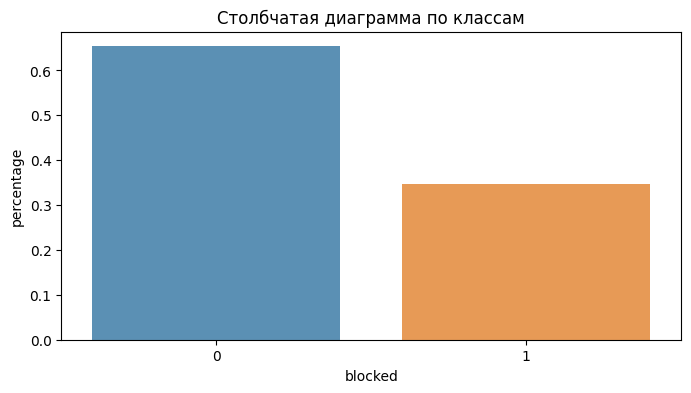

In [66]:
print('Соотношение классов:')
class_frequency = data['blocked'].value_counts(normalize=True)
print(class_frequency)

fig, ax = plt.subplots(figsize=(8, 4))
g = sns.barplot(x=class_frequency.index, y=class_frequency.values, alpha=0.8)
sns.set_style('darkgrid')
g.set(ylabel='percentage')
plt.title('Столбчатая диаграмма по классам')
plt.show()

Классы несбалансированы.

#### 2.8. Проверка на мультиколлинеарность

In [67]:
phik_overview = data.phik_matrix()
phik_overview.style.background_gradient()

interval columns not set, guessing: ['lessons_delivered', 'mean_lesson_price', 'lessons_given', 'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved', 'blocked', 'is_email_confirmed', 'lesson_duration', 'lesson_cost', 'is_display', 'review_num', 'price_mean', 'price_external_mean', 'amount_to_pay_sum', 'amount_to_pay_less_price', 'lesson_price_std', 'review_exit', 'new_teacher']


,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,lesson_cost,is_display,review_num,price_mean,price_external_mean,amount_to_pay_sum,amount_to_pay_less_price,lesson_price_std,review_exit,new_teacher,few_lessons
lessons_delivered,1.000000,0.000000,0.892794,0.370131,0.354811,0.961662,0.130648,0.082338,0.000000,0.286408,0.000000,0.440835,0.189641,0.418529,0.800622,0.741321,0.279544,0.000000,0.037256,0.157394
mean_lesson_price,0.000000,1.000000,0.000000,0.129645,0.079082,0.241609,0.113565,0.000000,0.243443,0.541222,0.000000,0.209113,0.477002,0.423383,0.170305,0.000000,0.551330,0.000000,0.089767,0.050023
lessons_given,0.892794,0.000000,1.000000,0.496959,0.414314,0.900676,0.187092,0.188701,0.000000,0.282237,0.000000,0.472148,0.203584,0.416971,0.847233,0.786583,0.411138,0.000000,0.000000,0.195339
lessons_started_fraction,0.370131,0.129645,0.496959,1.000000,0.393609,0.364243,0.381950,0.072121,0.000000,0.218523,0.000000,0.263127,0.185708,0.122257,0.530483,0.313056,0.000000,0.130137,0.000000,0.344588
lessons_per_pupil,0.354811,0.079082,0.414314,0.393609,1.000000,0.404057,0.264416,0.000000,0.052482,0.129572,0.040949,0.175424,0.000000,0.201239,0.455446,0.348357,0.000000,0.000000,0.069629,0.444711
money_recieved,0.961662,0.241609,0.900676,0.364243,0.404057,1.000000,0.102420,0.122857,0.000000,0.317270,0.000000,0.483455,0.201798,0.434488,0.879370,0.739508,0.282048,0.000000,0.000000,0.077159
blocked,0.130648,0.113565,0.187092,0.381950,0.264416,0.102420,1.000000,0.000000,0.000000,0.076468,0.000000,0.102570,0.105495,0.114849,0.160977,0.107265,0.043493,0.012742,0.107926,0.197945
is_email_confirmed,0.082338,0.000000,0.188701,0.072121,0.000000,0.122857,0.000000,1.000000,0.000000,0.139086,0.000000,0.319977,0.081528,0.038004,0.167818,0.099103,0.000000,0.000000,0.000000,0.019164
lesson_duration,0.000000,0.243443,0.000000,0.000000,0.052482,0.000000,0.000000,0.000000,1.000000,0.171889,0.000000,0.000000,0.288111,0.392763,0.022304,0.000000,0.000000,0.000000,0.000000,0.016983
lesson_cost,0.286408,0.541222,0.282237,0.218523,0.129572,0.317270,0.076468,0.139086,0.171889,1.000000,0.134919,0.310039,0.720103,0.585554,0.367722,0.288195,0.204591,0.000000,0.233233,0.158805


Обнаружена высокая корреляция между признаками amount_to_pay_sum, amount_to_pay_less_price, lessons_delivered, money_recieved, lessons_given. Так как мы не будем строить линейные модели, то оставим эти признаки.

Выводы: В результате предобработки данных были:
- признаки, содержащие дату, приведены к типу datetime;
- дублирующие значения удалены;
- датафреймы объеденены;
- созданы новые признаки;
- обработаны пропущенные значения;
- удалены маинформативные признаки.

### 3. Обучение моделей

#### 3.1. Подготовка признаков для построения моделей

In [68]:
X = data.drop(['blocked'], axis=1)
y = data['blocked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1121, 19) (481, 19) (1121,) (481,)


In [69]:
cat_features = X.select_dtypes(include='object').columns.tolist()
cat_features

[]

#### 3.2. Построение модели

В качестве модели выберем CatBoostClassifier

In [70]:
def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 320, 323),
        "depth": trial.suggest_int("depth", 5, 8),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 6),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.08, 0.1),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced"]),# "None"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", [ "Bernoulli"]) #, "Bayesian","MVS"])
    }
    train_pool = Pool(X_train, 
                  label=y_train
                      )
    test_pool = Pool(X_test, 
                  label=y_test
                    )
    model_cbc = CatBoostClassifier(**param, thread_count=-1, random_seed=RANDOM_STATE, verbose=0)                                              
    score_cbc = cross_val_score(model_cbc, X_train, y_train, cv=5, scoring='f1').mean()
    return score_cbc
sampler = optuna.samplers.RandomSampler(seed=SEED)
study_cbc = optuna.create_study(sampler=sampler, direction='maximize')
study_cbc.optimize(objective, n_trials=6, show_progress_bar=True)
print('Best hyperparameters:', study_cbc.best_params)
print('Best f1:', study_cbc.best_value)

[I 2024-04-09 16:29:13,403] A new study created in memory with name: no-name-901b3d2b-b1cd-4a42-982f-d8a8bf5f5cfa


  0%|          | 0/6 [00:00<?, ?it/s]

[I 2024-04-09 16:29:15,535] Trial 0 finished with value: 0.5943090334970623 and parameters: {'iterations': 321, 'depth': 8, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.09197316968394073, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.5943090334970623.
[I 2024-04-09 16:29:17,306] Trial 1 finished with value: 0.5921942110177405 and parameters: {'iterations': 322, 'depth': 7, 'l2_leaf_reg': 2, 'colsample_bylevel': 0.09939819704323989, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.5943090334970623.
[I 2024-04-09 16:29:18,753] Trial 2 finished with value: 0.5980920747006794 and parameters: {'iterations': 321, 'depth': 7, 'l2_leaf_reg': 4, 'colsample_bylevel': 0.08582458280396084, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 2 with value: 0.5980920747006794.
[I 2024-04-09 16

Выводы:

В результате построения модели было получено <b>f1 = 0.62</b> на тренировочной выборке с гиперпараметрами:
- iterations: 320, 
- depth: 6, 
- l2_leaf_reg: 2,
- colsample_bylevel: 0.09818640804157565, 
- auto_class_weights: Balanced, 
- boosting_type: Plain, 
- bootstrap_type: Bernoulli.

### 4. Тестирование модели

In [71]:
model_cbc = CatBoostClassifier(**study_cbc.best_params, random_state=RANDOM_STATE, verbose=False)
model_cbc.fit(X_train, y_train)
preds_test = model_cbc.predict(X_test)
score_test = f1_score(preds_test, y_test)
print(f'f1 для тестовой выборки: {score_test}')

f1 для тестовой выборки: 0.6804123711340205


In [72]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.87      0.72      0.78       314
           1       0.60      0.79      0.68       167

    accuracy                           0.74       481
   macro avg       0.73      0.75      0.73       481
weighted avg       0.77      0.74      0.75       481



In [73]:
cm = confusion_matrix(y_test, preds_test)
cm

array([[225,  89],
       [ 35, 132]])

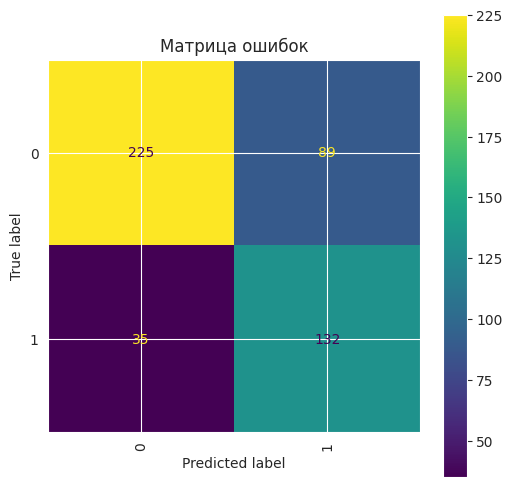

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_cbc.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation="vertical")
plt.title('Матрица ошибок')
plt.show()

Выводы:

- на тестовой выборке получено <b>f1 = 0.68</b>

- из матрицы ошибок следует:
    - правильно предсказанные классы - TN = 225 и TP = 132;
    - ошибочно предсказанные классы FN = 35 и FP = 89

### 4. Важность признаков

In [ ]:
feat_importances = pd.Series(model_cbc.feature_importances_, X_train.columns).sort_values()
feat_importances.plot(kind='barh');

In [ ]:
explainer = shap.TreeExplainer(model_cbc)

val_dataset = Pool(data=X_test, label=y_test)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test)

Выводы:
- наиболее важными признаками являются lessons_started_fraction и lessons_per_pupil.


#### ОБЩИЕ ВЫВОДЫ:
В результате исследования определено:
- классы несбалансированы 2:1;
- в результате построения модели CatBoostClassifier было получено <b>f1 = 0.62</b> на тренировочной выборке с гиперпараметрами:
    - iterations: 320, 
    - depth: 6, 
    - l2_leaf_reg: 2,
    - colsample_bylevel: 0.09818640804157565, 
    - auto_class_weights: Balanced, 
    - boosting_type: Plain, 
    - bootstrap_type: Bernoulli.
- на тестовой выборке получено <b>f1 = 0.68</b>
- из матрицы ошибок следует:
    - правильно предсказанные классы - TN = 225 и TP = 132;
    - ошибочно предсказанные классы FN = 35 и FP = 89
- наиболее важными признаками являются lessons_started_fraction и lessons_per_pupil.